In [4]:
%reset -f

In [5]:
# Set to false if working on local env
onColab = True

model_path = './e1d1_conv_divided_set'

# Decide batch size and validation split
batch_size = 16
validation_split = 0.2
test_split = 0.05
epochs = 400

window = 600
stride = 10
# 864 / 16
telescope = 108

In [6]:
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Mounted at /gdrive
/gdrive/MyDrive/University/ANN/CHALLENGE2
e1d1_conv_divided_set.ipynb  gru_conv_ckpt   model.png
gru			     gru_conv.ipynb  smooth21
gru_ckpt		     gru.ipynb	     Training_smooth4.csv


In [7]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import sklearn
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

tf.config.list_physical_devices('GPU')

2.7.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
seed = 20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [9]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df.copy().values
    padding_len = len(df) % window

    if(padding_len != 0):
        # Compute padding length
        temp_df = temp_df[padding_len:]
        temp_label = temp_label[padding_len:]
        # padding_len = window - len(df)%window
        # if len(df.shape) > 1:
        #   padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        # else:
        #   padding  = np.zeros((padding_len), dtype='float64')
        # temp_df = np.concatenate((padding,df))
        # if len(df.shape) > 1:
        #   padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        # else:
        #   padding  = np.zeros((padding_len), dtype='float64')
        # temp_label = np.concatenate((padding,temp_label))
        # assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
      if len(df.shape) > 1:
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])
      else:
        dataset.append([[i] for i in temp_df[idx:idx+window]])
        labels.append([[i] for i in temp_label[idx+window:idx+window+telescope]])

    dataset = np.array(dataset)
    print(dataset.shape)
    labels = np.array(labels)

    return dataset, labels

In [10]:
def normalize(dataset, t=None):
    x_max = np.array([
        15.10668024063110514987329224823043,
        18.12289930343628086006901867222041,
        41.13880050659178522209913353435695,
        14.03598027229309153085523576010019,
        6.05636000633239746093750000000000,
        77.37161994934081121755298227071762,
        31.02441982269287734652607468888164
    ])
    x_min = np.array([
        -0.97207993984222407224393691649311,
        -8.45037973403930742222200933611020,
        -37.58172096252441463093418860808015,
        -9.02805981636046617211377451894805,
        -1.27586008548736540291201890795492,
        -6.00686032295226901567275490378961,
        -42.76922096252441463093418860808015
    ])
    if t is None or t == 'minmax':
        nd = (dataset - x_min) / (x_max - x_min)
        return nd
    elif t == 'mean_std':
        x_mean = dataset.mean()
        x_std = dataset.std()
        nd = (dataset - x_mean) / x_std
        return nd

In [11]:
def chunk(dataset, window, telescope, stride):
  """
  divide the dataset in chunks. 
  It keeps the right-most elements and discard the left ones, if size and stride are not compatible with dimensions. 
  """
  size = window + telescope
  X = []
  Y = []
  for i in range(len(dataset) - size, -1, -stride):
    X.append(dataset[i: i + window])
    Y.append(dataset[i + window: i + size])
  X.reverse()
  Y.reverse()
  return (np.array(X), np.array(Y))

In [12]:
dataset_paths = np.array(['./smooth21/set0.csv',
                          './smooth21/set1.csv',
                          './smooth21/set2.csv',
                          './smooth21/set3.csv',
                          './smooth21/set4.csv',
                          './smooth21/set5.csv',
                          './smooth21/set6.csv'
                        ])


X_train = [] 
y_train = []

for s in dataset_paths:
    dataset = pd.read_csv(s)
    normalized_ds = normalize(dataset)
    X_train_tmp, y_train_tmp = chunk(normalized_ds, window, telescope, stride)

    for x in X_train_tmp:
        X_train.append(x)
    for x in y_train_tmp:
        y_train.append(x)

X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [13]:
# shuffle data so that 
X_train.shape, y_train.shape

((5307, 600, 7), (5307, 108, 7))

In [14]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        # axs[i].set_ylim(0,1)
    plt.show()

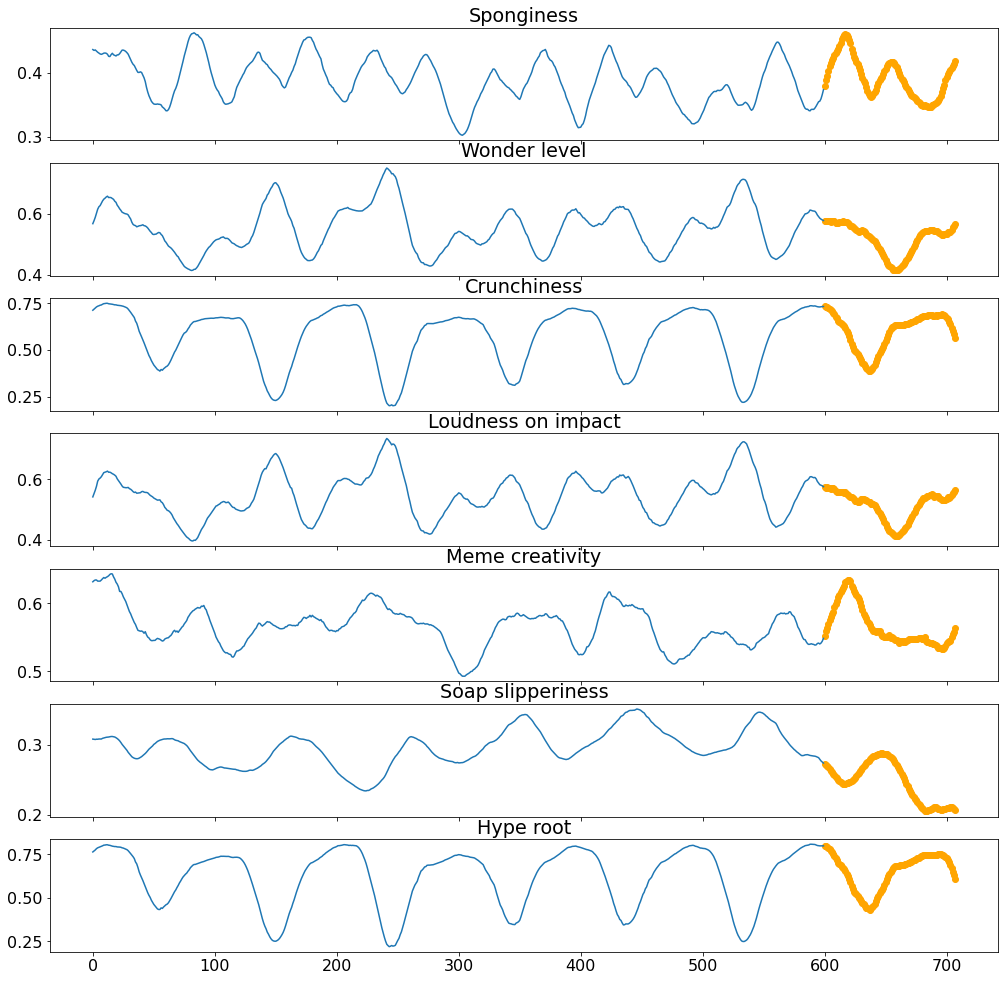

In [15]:
inspect_multivariate(X_train, y_train, dataset.columns, telescope, 4500)

In [16]:
input_shape = (window, 7)
output_shape = (telescope, 7)

In [17]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    # E1D1
    n_features = input_shape[1]
    n_past = input_shape[0]
    n_future = output_shape[0]

    #
    encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))    
    conv = tfkl.Conv1D(512, 3, padding='same', activation='relu')
    encoder_l1 = tf.keras.layers.LSTM(256, return_state=True)
    encoder_outputs1 = encoder_l1(conv(encoder_inputs))

    encoder_states1 = encoder_outputs1[1:]

    #
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

    #
    decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    #
    model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    model_e1d1.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    return model_e1d1

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 7)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 600, 512)     11264       ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 256),        787456      ['conv1d[0][0]']                 
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

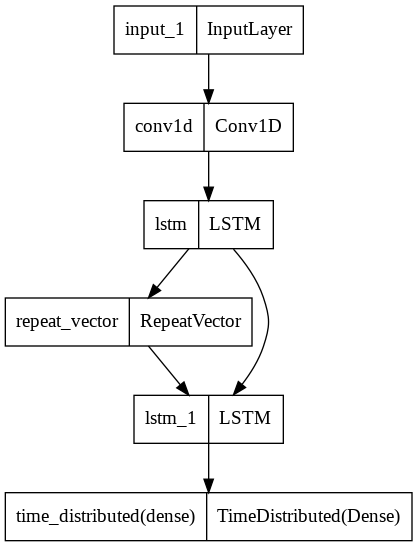

In [18]:
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)


In [19]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split = validation_split,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True),
        # tfk.callbacks.ModelCheckpoint(model_path + '_ckpt', save_best_only=True)
    ]
).history

Epoch 1/400
266/266 [==============================] - 28s 45ms/step - loss: 0.0106 - mae: 0.0707 - val_loss: 0.0092 - val_mae: 0.0739
Epoch 2/400
266/266 [==============================] - 11s 42ms/step - loss: 0.0070 - mae: 0.0598 - val_loss: 0.0081 - val_mae: 0.0617
Epoch 3/400
266/266 [==============================] - 11s 43ms/step - loss: 0.0067 - mae: 0.0581 - val_loss: 0.0084 - val_mae: 0.0659
Epoch 4/400
266/266 [==============================] - 12s 43ms/step - loss: 0.0064 - mae: 0.0570 - val_loss: 0.0081 - val_mae: 0.0664
Epoch 5/400
266/266 [==============================] - 12s 44ms/step - loss: 0.0060 - mae: 0.0553 - val_loss: 0.0084 - val_mae: 0.0697
Epoch 6/400
266/266 [==============================] - 12s 45ms/step - loss: 0.0050 - mae: 0.0514 - val_loss: 0.0047 - val_mae: 0.0503
Epoch 7/400
266/266 [==============================] - 12s 45ms/step - loss: 0.0044 - mae: 0.0483 - val_loss: 0.0042 - val_mae: 0.0475
Epoch 8/400
266/266 [==============================] - 

In [20]:
model.save(model_path)

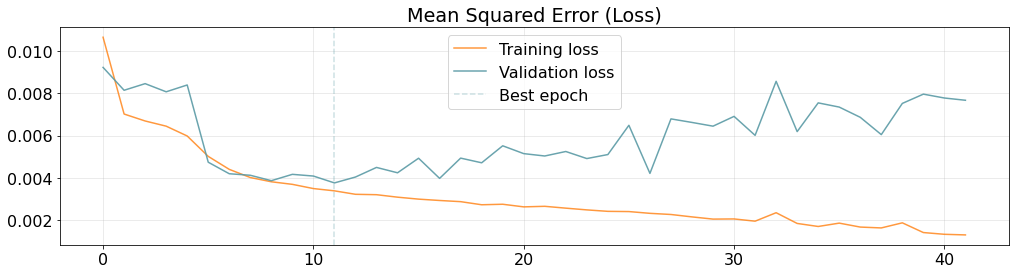

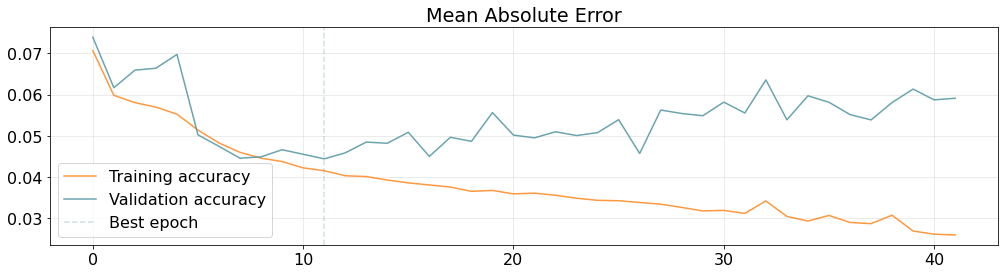

In [21]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# plt.figure(figsize=(18,3))
# plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
# plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
# plt.legend()
# plt.grid(alpha=.3)
# plt.show()

In [22]:
# model = tfk.models.load_model(model_path)

In [ ]:
# model = tfk.models.load_model(model_path + "_ckpt")

In [24]:
x, y = X_train, y_train

predictions = model.predict(x)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(5307, 108, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.0032497284>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.040425207>)

In [25]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

In [26]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [27]:
reg_telescope = 864
X_test_reg, y_test_reg  = chunk(normalized_ds, window, reg_telescope, stride)
X_test_reg = X_test_reg[-10:]
y_test_reg = y_test_reg[-10:]
X_test_reg.shape, y_test_reg.shape

((10, 600, 7), (10, 864, 7))

In [28]:
# Autoregressive Forecasting
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [29]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

(<tf.Tensor: shape=(), dtype=float32, numpy=0.012341022>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.089295745>)

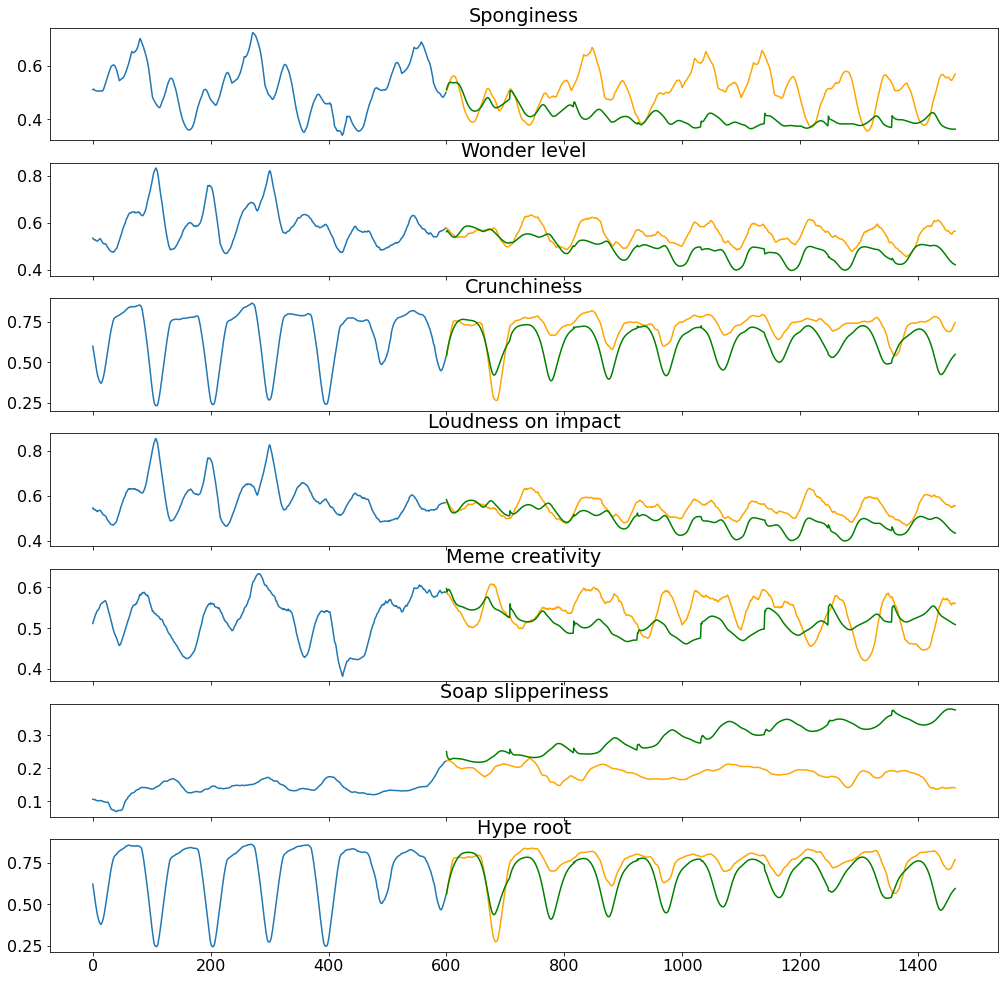

In [33]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, dataset.columns, reg_telescope)